# Calculate Future CAPE

## Data preparation

In [169]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

In [173]:
# open dataset
# rho_parcel from David
rho_2071_01_15 = xr.open_dataset("data/ssp585_rho_2017_01_15_NCAR_CESM2-WACCM.nc") 
# temperature file at different pressure level
ta_2071_01_15 = xr.open_dataset("data/ssp585_ta_2017_01_15_NCAR_CESM2-WACCM.nc")

# modify rho_p lat and lon
lat = ta_2071_01_15.lat
lon = ta_2071_01_15.lon
rho_2071_01_15["lat"] = lat
rho_2071_01_15["lon"] = lon
rho_2071_01_15

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 47, p: 10)
Coordinates:
  * lon      (lon) float64 271.2 272.5 273.8 275.0 ... 325.0 326.2 327.5 328.8
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 8.01 8.953 9.895
  * p        (p) float32 1e+05 9e+04 8e+04 7e+04 ... 4e+04 3e+04 2e+04 1e+04
Data variables:
    rho      (p, lat, lon) float32 ...

In [174]:
# interpolate pressure = 80000 & 90000 Pa in tas file
ta_2071_01_15_plev9e04 = ta_2071_01_15.interp(plev = 90000)
ta_2071_01_15_plev8e04 = ta_2071_01_15.interp(plev = 80000)
# concatenant the pressure levels together
ta_2071_01_15 = xr.concat([ta_2071_01_15, ta_2071_01_15_plev8e04, ta_2071_01_15_plev9e04], dim = "plev")

## Calculate enviornmental rho 

In [175]:
# Calculate environmental_rho at different pressure level
# ideal gas law p = rho*R*T
rho_e_list = []
def calculate_rho_e(ta, plev_list):
    R = 287 # J K**-1kg**-1 for dry air
    for pressure in plev_list:
        rho_e_i = pressure/(R*ta.sel(plev = pressure))
        rho_e_list.append(rho_e_i)  
    return rho_e_list

# go through the pressure list from 1e4 Pa to 1e5 Pa
plev_list = np.arange(10000, 100001, 10000)
# Calculate environmental rho
rho_e_list = calculate_rho_e(ta, plev_list)
rho_e_ds = xr.concat(rho_e_list, dim = "plev")
rho_e_2071_01_15 = rho_e_ds.rename({"ta":"rho_e"}) # rename
rho_e_2071_01_15

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 47, plev: 10)
Coordinates:
  * lat      (lat) float64 -19.32 -18.38 -17.43 -16.49 ... 8.01 8.953 9.895
  * lon      (lon) float64 271.2 272.5 273.8 275.0 ... 325.0 326.2 327.5 328.8
  * plev     (plev) float64 1e+04 2e+04 3e+04 4e+04 ... 7e+04 8e+04 9e+04 1e+05
Data variables:
    rho_e    (plev, lat, lon) float64 0.1734 0.1736 0.1738 ... 1.165 1.165 1.164

## CAPE calculation 

In [197]:
def compute_cape(rho_e, rho_p, plev_list):
    """
    Calculate cape using sum_{i=1}^10 dp H(b_i) b_i
    where dp = 1e4 Pa
    H is the Heaviside unit step function
    b_i = 1/rho_p_i - 1/rho_e_i}
    1/rho_p_i = the parcel density at pressure level i
    rho_e_i = environmental density at pressure level i 
    """
   
    cape_sum = np.zeros((32,47)) # create an empty array
    for pressure in plev_list:
        rho_e_i = rho_e.sel(plev = pressure).rho_e # select rho_e at pressure level i
        rho_p_i = rho_p.sel(p = pressure).rho # select rho_p at pressure level i
        b_i = 1/rho_p_i - 1/rho_e_i 
        cape_i = np.heaviside(b_i, 0)*b_i*10000 # calculate cape
        cape_i.values = np.nan_to_num(cape_i.values) # replace nan values to zero. There are a lot of nan values over land in high pressure levels (e.g. 90000, 1e5 Pa)
        cape_sum += cape_i
    cape_sum = cape_sum.drop(['p','plev']) # cape is vertical integrations, so p and plev are not useful
    cape_sum.attrs["units"] = "J kg**-1"
    cape_sum.attrs["long_name"] = "Convective available potential energy"
    return cape_sum
    

In [198]:
plev_list = np.arange(10000, 100001, 10000)
cape_2071_01_15 = compute_cape(rho_e_2071_01_15, rho_2071_01_15, plev_list)

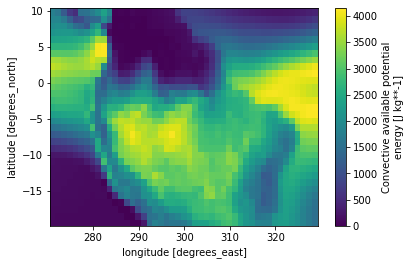

In [199]:
cape_2071_01_15.plot()

<ipython-input-200-3b212c83dd96>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


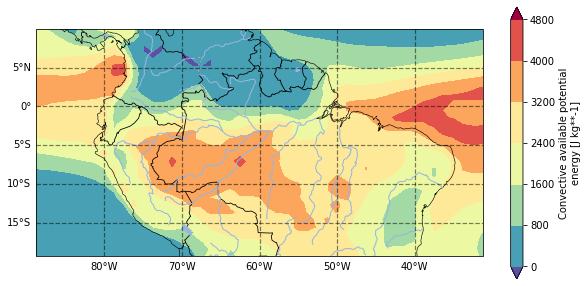

In [200]:
# create a pretty map
import arrow
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
def map():
  # create space for drawing
  proj = ccrs.PlateCarree()  #create coordinate
  fig = plt.figure(figsize=(10, 5))  #create figure
  ax = fig.subplots(1, 1, subplot_kw={'projection': proj})  #create sub-plot
  # set map parameters
  ax.add_feature(cfeat.BORDERS.with_scale('50m'), linewidth=0.8)  #add borders
  ax.add_feature(cfeat.COASTLINE.with_scale('50m'), linewidth=0.6)  #add coastlines
  ax.add_feature(cfeat.RIVERS.with_scale('50m'))  #add rivers
  ax.add_feature(cfeat.LAKES.with_scale('50m'))  #add lakes
  # set up gridlines
  gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=1.2, color='k', alpha=0.5, linestyle='--')
  gl.xlabels_top = False  #remove x labels
  gl.ylabels_right = False  #remove y lables
  gl.xformatter = LONGITUDE_FORMATTER  #set x as lon
  gl.yformatter = LATITUDE_FORMATTER  #set y as lat
  return fig, ax

fig, ax = map()
cape_2071_01_15.plot.contourf(ax=ax, cmap='Spectral_r', extend='both',
        transform=ccrs.PlateCarree())
fig.show()